In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns
import pydot
import graphviz

In [2]:
tfd = tfp.distributions
tfl = tfp.layers

sns.set()

In [3]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [4]:
def syn_dataset3(n=150, n_tst=150,beta=2):
    # to allow for reproducibility 
    np.random.seed(43)
    # We're making the picking the input features randomly.
    x = np.random.rand(n)
    
    #Let's make the errors heterosckedastic(non-monotonic)
    eps = ((x-0.5)**2.)*np.random.randn(n)
    
    y = ((x**5)+eps)[:, np.newaxis]
    x = x[:, np.newaxis]
    
    # we're making the test inputs to be deterministic, probably different from the 
    # training input features
    x_tst = np.linspace(np.min(x),np.max(x), num=n_tst).astype(np.float32)
    x_tst = x_tst[:, np.newaxis]
    return y, x, x_tst

y, x_train, x_test = syn_dataset3()

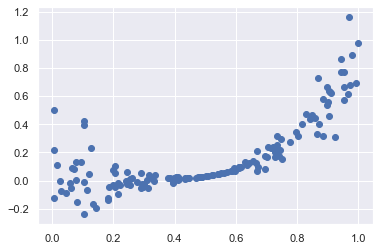

In [5]:
plt.scatter(x_train,y)
plt.show()

In [7]:
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.Sequential([
        tfl.DistributionLambda(lambda t : 
                                tfd.MultivariateNormalDiag(loc=tf.zeros(n),
                                                           scale_diag=tf.ones(n))),
    ])
    return prior_model

In [8]:
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf.keras.Sequential([
        tfl.VariableLayer(tfl.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfl.MultivariateNormalTriL(n)
    ])
    return posterior_model

In [9]:
N=x_train.shape[0]

inputs = tf.keras.layers.Input(shape=(1,)) 
hidden1_sd = tfl.DenseVariational(30, posterior, prior, kl_weight=1/N, activation='relu')(inputs)
hidden1_sd = tfl.DenseVariational(20, posterior, prior, kl_weight=1/N)(hidden1_sd)
hidden2_sd = tfl.DenseVariational(20, posterior, prior, kl_weight=1/N)(hidden1_sd)
out2 = tfl.DenseVariational(1, posterior, prior, kl_weight=1/N)(hidden2_sd)

hidden1_m = tfl.DenseVariational(30, posterior, prior, kl_weight=1/N, activation='relu')(inputs)
hidden1_m = tfl.DenseVariational(20, posterior, prior, kl_weight=1/N)(hidden1_m)
hidden2_m = tfl.DenseVariational(20, posterior, prior, kl_weight=1/N)(hidden1_m)
out1 = tfl.DenseVariational(1, posterior, prior, kl_weight=1/N)(hidden2_m)

params = tf.keras.layers.Concatenate()([out1,out2]) 
dist = tfp.layers.DistributionLambda(
    lambda t: tfd.Normal(loc=t[:,:1],scale=1e-5+tf.math.softplus(t[:, 1:]))
    )(params) 

model_flex_both = tf.keras.Model(inputs=inputs, outputs=dist)

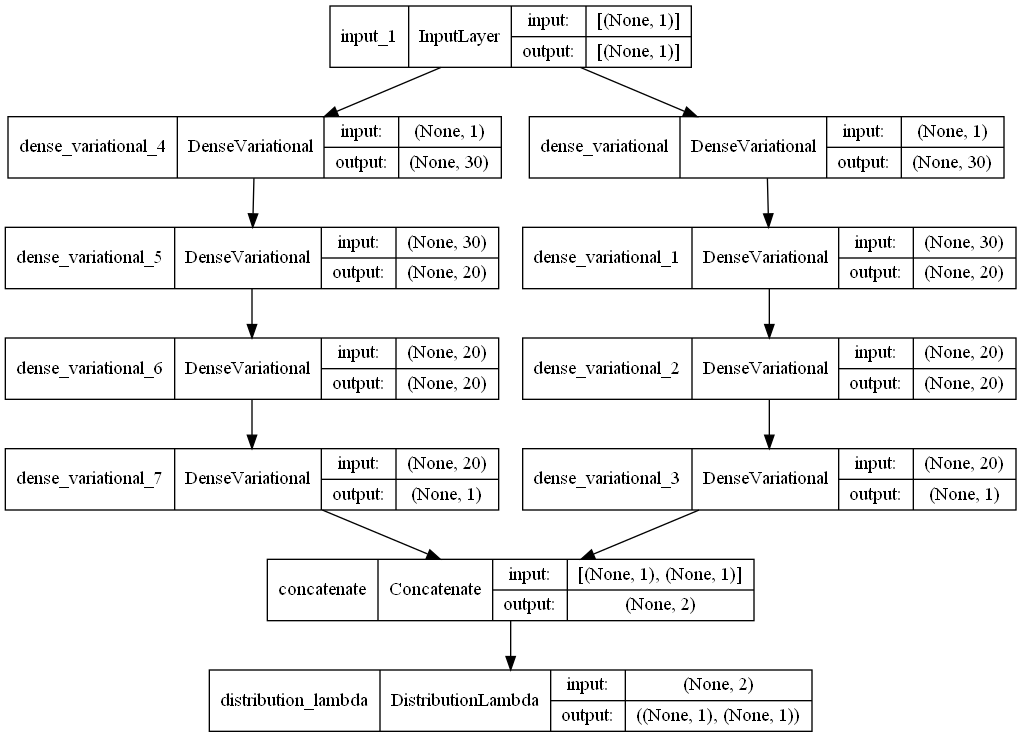

In [10]:
tf.keras.utils.plot_model(model_flex_both,show_shapes=True)

In [11]:
# compiling the model
model_flex_both.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)

In [13]:
#model_flex_both.summary()
model_flex_both.fit(x_train, y, epochs=500, verbose=False);

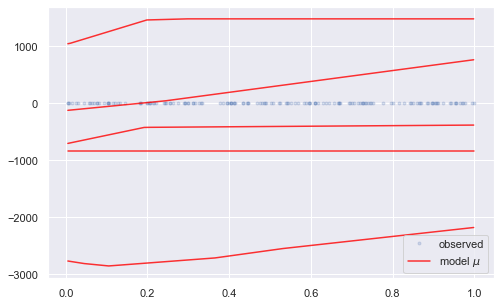

In [14]:
plt.figure(figsize=[8, 5])  # inches
plt.plot(x_train, y,'b.',alpha=0.2, label='observed');

for _ in range(5):
    y_model = model_flex_both(x_test)
    y_hat = y_model.mean()
    #y_hat_m2std = y_hat - 2 * y_model.stddev()
    #y_hat_p2std = y_hat + 2 * y_model.stddev()
    
    if _ == 0:
        plt.plot(x_test, y_hat, color='red', alpha=0.8, label='model $\mu$')
        #plt.plot(x_tst_syn_ds3, y_hat_m2std, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
        #plt.plot(x_tst_syn_ds3, y_hat_p2std, color='green', alpha=0.8)
    else:
        plt.plot(x_test, y_hat, color='red', alpha=0.8)
        #plt.plot(x_tst_syn_ds3, y_hat_m2std, color='green', alpha=0.8)
        #plt.plot(x_tst_syn_ds3, y_hat_p2std, color='green', alpha=0.8)
plt.legend(loc='best')
plt.show()